## libraries and globals

In [1]:
import json 
from unidecode import unidecode
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import re
from scipy.stats import entropy
from difflib import SequenceMatcher
from itertools import combinations, product
import networkx as nx

In [2]:
# BITEXT FUNCTIONS
good_pos = {'NOUN','ADJ','VERB'}
excluded_lemmas = {'be', 'other', 'have', 'let', 'one', 'lot', 'same', 'such', 't', 's'}

## merging functions

In [3]:
def string_mergable(ci,cj):
    match_ij = SequenceMatcher(None, ci, cj).find_longest_match()
    return match_ij.size >= 3 and match_ij.size/len(ci) >= 0.5 and match_ij.size/len(cj) >= 0.5

def distrib_mergable(wi,wj):
    return len(set(wi) & set(wj)) / max(len(set(wi)),len(set(wj))) >= 0.5

def merge_lemmas(tl_json):
    tes = tl_json['tes']
    te_words = tl_json['te_words']
    mergers = nx.Graph()
    merger_dict = {}
    for sw in tes:
        for ci in tes[sw]:
            mergers.add_node((sw,ci), freq=sum(te_words[sw][ci].values()))
        for ci,cj in combinations(tes[sw],2):
            if string_mergable(ci,cj):
                mergers.add_edge((sw,ci), (sw,cj))
    for swi,swj in combinations(tes, 2):
        for ci,cj in product(tes[swi],tes[swj]):
            if string_mergable(ci,cj) and distrib_mergable(te_words[swi][ci], te_words[swj][cj]):
                mergers.add_edge((swi,ci), (swj,cj))
    for c in nx.connected_components(mergers):
        for ci in c: 
            cmax = max(c, key = nx.get_node_attributes(mergers, 'freq').get)
            merger_dict[ci] = cmax
    return merger_dict

## aggregate results

In [4]:
def glossmatch(gi, sw):
    return sw in re.split('[^a-zA-Z]', gi)

def special_char_re(tfrag):
    for c in '?().|':
        tfrag = tfrag.replace(c, '\\%s' % c)
    tfrag = tfrag[0] + tfrag[1:].replace('^', '\\^')
    tfrag = tfrag[:-1].replace('$', '\\$') + tfrag[-1]
    return tfrag

In [5]:
def get_hAperB(dflsub, b, a):
    all_ents = []
    for ax in filter(lambda ax : ax != None, dflsub[a].unique()):
        counts = Counter(dflsub[dflsub[a] == ax][b])
        all_ents.append((entropy(list(counts.values())), sum(counts.values())))
    macro_haperb = sum(map(lambda x : x[0]*x[1], all_ents))/sum(map(lambda x : x[1], all_ents))
    micro_haperb = sum(map(lambda x : x[0], all_ents))/len(all_ents)
    return macro_haperb, micro_haperb

In [ ]:
def get_results(tl):
    print(tl)
    fin = open('./generated/doreco_output/%s.json' % tl,'r')
    tl_json = json.loads(fin.read())
    E,F = zip(*[([w.split('/')[2] for w in l.strip('\n').split(' ||| ')[1].split() 
                  if w.split('/')[3] in good_pos and w.split('/')[2] not in excluded_lemmas],
                  l.strip('\n').split(' ||| ')[0].split())
                 for l in open('./generated/doreco_bitexts/%s.spc' % tl)])
    M = {l.split('\t')[0]:l.split('\t')[1].split() for l in open('./generated/doreco_morphology/%s.master.tsv' % tl)}
    #
    mergers = merge_lemmas(tl_json)
    #
    ew2ix = defaultdict(lambda : set())
    for ei,e in enumerate(E):
        for w in e:
            ew2ix[w].add(ei)
    #
    builder = []
    #
    for sw in tl_json['tes']:
        unmapped = ew2ix[sw].copy()
        # track remaining sw instances not covered yet.
        for tfrag in tl_json['tes'][sw]:
            tfrag_m = mergers[sw,tfrag]
            #print(sw, tfrag)
            unmapped -= set(tl_json['tes'][sw][tfrag])
            wrds = {w.strip('$^'):v for w,v in tl_json['te_words'][sw][tfrag].items()}
            for i in tl_json['tes'][sw][tfrag]:
                W = [w for w in F[i] if re.search(special_char_re(tfrag), unidecode(w).lower()) != None]
                w = max(W, key = lambda w : (wrds[unidecode(w)] if unidecode(w) in wrds else 0), default=None)
                gloss_has_sw = any(map(lambda gi: glossmatch(gi,sw), M[w])) if w in M else False
                sentence_glosses_have_sw = sum(map(lambda tw : any(map(lambda gi : glossmatch(gi,sw), M[tw])), 
                                                   filter(lambda tw: tw in M, F[i])))
                gloss = next((m for f in F[i] if f in M for m in M[f] if glossmatch(m,sw)),None)
                builder.append({'sw' : sw, 'tw' : w, 'tfrag' : tfrag, 'tfrag_m' : tfrag_m, 'i' : i, 'correct' : gloss_has_sw, 
                                'gloss' : gloss,'baseline' : sentence_glosses_have_sw/len(F[i])})
                #if sentence_glosses_have_sw and not gloss_has_sw: print(sw, tfrag, w, F[i], [M[f] if f in M else [] for f in F[i]])
        for i in unmapped:
            sentence_glosses_have_sw = sum(map(lambda tw : any(map(lambda gi : glossmatch(gi,sw), M[tw])), filter(lambda tw: tw in M, F[i])))
            builder.append({'sw' : sw, 'tw' : None, 'tfrag' : None, 'tfrag_m' : None, 'i' : i, 'correct' : False, 
                            'gloss' : None, 'baseline' : sentence_glosses_have_sw/len(F[i])})
                
    return pd.DataFrame(builder)

df = {tl.strip() : get_results(tl.strip()) for tl in open('doreco_doculects.txt')
     if os.path.isfile('./generated/doreco_morphology/%s.master.tsv' % tl.strip()) }

In [65]:
builder = []
for l,dfl in df.items():
    sw_count = Counter(dfl[dfl.baseline > 0].sw)
    good_sw = set(filter(lambda sw : sw_count[sw] >= 3, dfl.sw.unique()))
    if len(good_sw) < 100: continue
    #
    dflsub = dfl[(dfl.baseline > 0) & (dfl.sw.isin(good_sw))]
    weights = np.array([1/sw_count[sw] for sw in dflsub.sw])
    #
    macro_c_per_g, micro_c_per_g = get_hAperB(dflsub[dflsub.correct], 'tfrag', 'gloss')
    macro_g_per_c, micro_g_per_c = get_hAperB(dflsub[dflsub.correct], 'gloss', 'tfrag')
    #

    macro_cm_per_g, micro_cm_per_g = get_hAperB(dflsub[dflsub.correct], 'tfrag_m', 'gloss')
    macro_g_per_cm, micro_g_per_cm = get_hAperB(dflsub[dflsub.correct], 'gloss', 'tfrag_m')
    #,
    macro_mean = dflsub[dflsub.baseline > 0].correct.mean()
    macro_base = dflsub[dflsub.baseline > 0].baseline.mean()
    #
    micro_mean = np.multiply(weights, dflsub[dflsub.baseline > 0].correct).sum() / len(good_sw)
    micro_base = np.multiply(weights, dflsub[dflsub.baseline > 0].baseline).sum() / len(good_sw)
    #
    
    print('%s\t%.2f %.2f\t%.2f %.2f\t%d' % (l, macro_mean, macro_base, micro_mean, micro_base, len(good_sw)))
    builder.append({'doculect' : l, 
                    'mean accuracy (macro-averaged)' : macro_mean, 'baseline (macro-averaged)' : macro_base,
                   'mean accuracy (micro-averaged)' : micro_mean, 'baseline (micro-averaged)' : micro_base, 
                   'mean entropy gloss per lemma (macro-averaged)' : macro_g_per_c, 
                   'mean entropy gloss per lemma (micro-averaged)' : micro_g_per_c, 
                   'mean entropy lemma per gloss (macro-averaged)' : macro_c_per_g, 
                   'mean entropy lemma per gloss (micro-averaged)' : micro_c_per_g, 
                   'mean entropy gloss per merged lemma (macro-averaged)' : macro_g_per_cm, 
                   'mean entropy gloss per merged lemma (micro-averaged)' : micro_g_per_cm, 
                   'mean entropy merged lemma per gloss (macro-averaged)' : macro_cm_per_g, 
                   'mean entropy merged lemma per gloss (micro-averaged)' : micro_cm_per_g, 
                   'n good sw' : len(good_sw)})
results = pd.DataFrame(builder)
results.set_index('doculect')

apah1238	0.91 0.33	0.88 0.32	120
arap1274	0.94 0.39	0.93 0.41	262
beja1238	0.90 0.45	0.93 0.45	358
cabe1245	0.86 0.13	0.86 0.13	182
cash1254	0.87 0.21	0.82 0.20	188
dolg1241	0.91 0.15	0.87 0.14	328
goem1240	0.94 0.12	0.88 0.12	266
goro1270	0.96 0.23	0.95 0.23	275
hoch1243	0.85 0.15	0.86 0.14	151
jeha1242	0.94 0.21	0.92 0.22	111
jeju1234	0.85 0.23	0.81 0.23	106
kaka1265	0.88 0.10	0.87 0.11	209
kama1351	0.98 0.25	0.97 0.25	399
komn1238	0.96 0.31	0.95 0.33	370
nngg1234	0.94 0.28	0.94 0.30	296
pnar1238	0.93 0.07	0.89 0.07	195
ruul1235	0.94 0.33	0.93 0.34	228
savo1255	0.88 0.10	0.92 0.10	131
sout2856	0.91 0.10	0.91 0.09	246
sumi1235	0.91 0.23	0.87 0.23	149
taba1259	0.87 0.14	0.83 0.13	122
teop1238	0.96 0.18	0.96 0.18	178
trin1278	0.91 0.14	0.90 0.14	309
urum1249	0.92 0.14	0.89 0.14	264
vera1241	0.86 0.13	0.88 0.12	108


,mean accuracy (macro-averaged),baseline (macro-averaged),mean accuracy (micro-averaged),baseline (micro-averaged),mean entropy gloss per lemma (macro-averaged),mean entropy gloss per lemma (micro-averaged),mean entropy lemma per gloss (macro-averaged),mean entropy lemma per gloss (micro-averaged),mean entropy gloss per merged lemma (macro-averaged),mean entropy gloss per merged lemma (micro-averaged),mean entropy merged lemma per gloss (macro-averaged),mean entropy merged lemma per gloss (micro-averaged),n good sw
doculect,,,,,,,,,,,,,
apah1238,0.907313,0.334811,0.882402,0.316517,0.252424,0.101768,0.073659,0.053300,0.224183,0.108280,0.054989,0.039538,120
arap1274,0.935228,0.391958,0.934018,0.405301,1.251322,0.549039,0.089557,0.062119,1.293486,0.560179,0.075547,0.057149,262
beja1238,0.896929,0.445123,0.934931,0.454092,0.757068,0.348793,0.177616,0.074451,0.781824,0.360560,0.137763,0.056645,358
cabe1245,0.855823,0.130754,0.856562,0.126850,0.458952,0.269588,0.025511,0.019960,0.444266,0.282732,0.016529,0.010333,182
cash1254,0.871354,0.206544,0.821198,0.203582,0.244247,0.145319,0.037686,0.031362,0.203034,0.134980,0.025893,0.021737,188
dolg1241,0.910115,0.149134,0.871455,0.142726,0.516228,0.336490,0.068526,0.038558,0.495022,0.342176,0.047148,0.026164,328
goem1240,0.936814,0.116817,0.881626,0.120920,0.037375,0.029122,0.036973,0.026325,0.072709,0.061688,0.018645,0.011231,266
goro1270,0.957537,0.230607,0.947959,0.232272,0.838125,0.456128,0.043148,0.019941,0.862067,0.489990,0.034592,0.014728,275
hoch1243,0.851922,0.152707,0.859354,0.144062,0.608196,0.408985,0.105974,0.071348,0.638871,0.431369,0.099299,0.064642,151


Acc = 0.911 | baseline = 0.204
[0.852 0.88  0.911 0.942 0.976]
Acc = 0.897 | baseline = 0.205
[0.81  0.875 0.893 0.934 0.971]
Acc = 0.077 | baseline = 0.057
[0.025 0.047 0.069 0.091 0.204]
Acc = 0.043 | baseline = 0.033
[0.02  0.029 0.039 0.053 0.093]
Acc = 0.393 | baseline = 0.407
[0.037 0.116 0.348 0.516 1.251]
Acc = 0.230 | baseline = 0.245
[0.029 0.089 0.249 0.349 0.549]


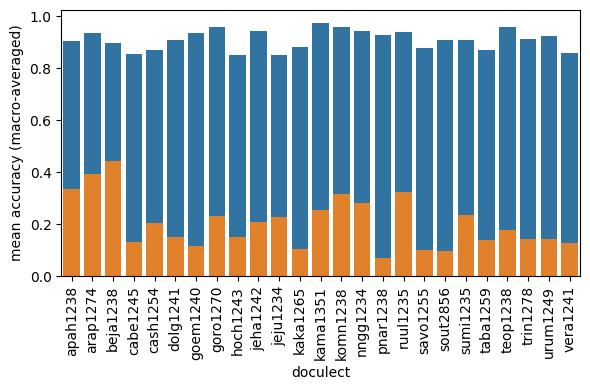

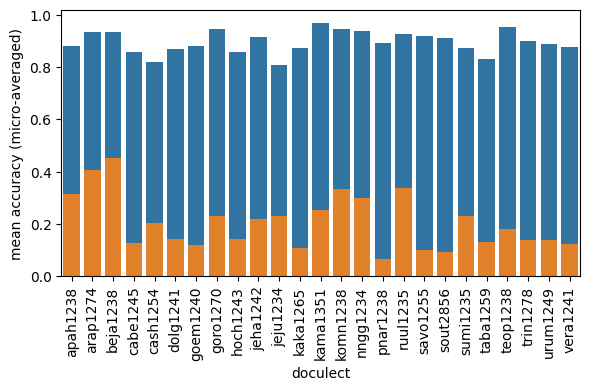

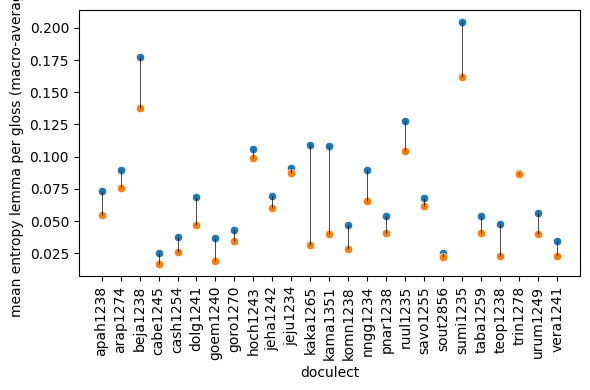

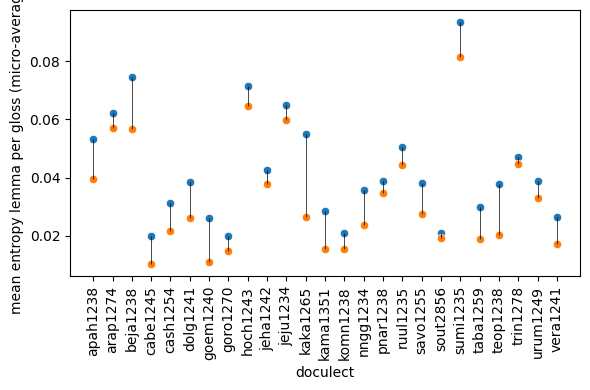

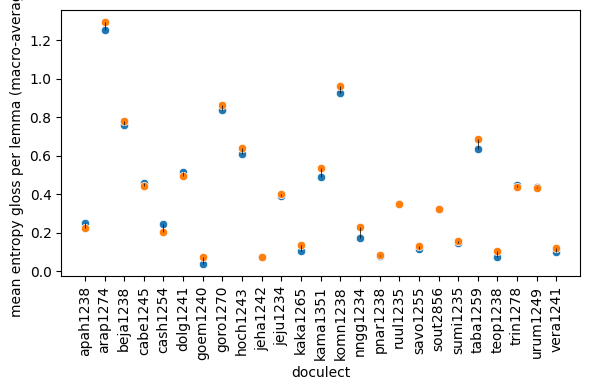

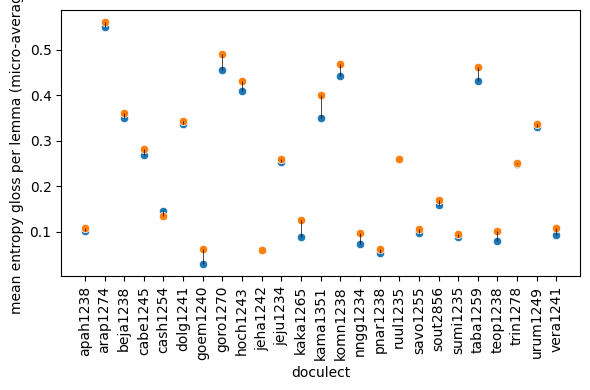

In [80]:
for f1, f2 in [['mean accuracy (macro-averaged)', 'baseline (macro-averaged)'],
               ['mean accuracy (micro-averaged)', 'baseline (micro-averaged)'],
               ['mean entropy lemma per gloss (macro-averaged)', 'mean entropy merged lemma per gloss (macro-averaged)'],
               ['mean entropy lemma per gloss (micro-averaged)', 'mean entropy merged lemma per gloss (micro-averaged)'],
               ['mean entropy gloss per lemma (macro-averaged)', 'mean entropy gloss per merged lemma (macro-averaged)'],
               ['mean entropy gloss per lemma (micro-averaged)', 'mean entropy gloss per merged lemma (micro-averaged)']]:           
    print('Acc = %.3f | baseline = %.3f' % (np.nanmean(results[f1]), np.nanmean(results[f2])))
    print(np.round(np.array([np.quantile(results[f1], x/4) for x in range(5)]),3))
    plt.figure(figsize=(6,4))
    if 'entropy' in f1:
        sns.scatterplot(data=results, x='doculect', y=f1)
        sns.scatterplot(data=results, x='doculect', y=f2)
        for i in range(len(results)):
            fmin, fmax = sorted([results.at[i,f1], results.at[i,f2]])
            plt.vlines(i, fmin,fmax, color='k', linewidth=0.5)
    else: 
        sns.barplot(data=results, x='doculect', y=f1)
        sns.barplot(data=results, x='doculect', y=f2)
    x = plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('/home/barend/Dropbox/Apps/Overleaf/Inferred Lexification (SigTyp 2025)/latex/figures/%s.png' % f1)

In [87]:
results['mean entropy gloss per lemma (macro-averaged)']-results['mean entropy gloss per merged lemma (macro-averaged)']

0     0.028242
1    -0.042165
2    -0.024756
3     0.014687
4     0.041213
5     0.021206
6    -0.035334
7    -0.023942
8    -0.030675
9    -0.000516
10   -0.011115
11   -0.031454
12   -0.048448
13   -0.032508
14   -0.057011
15   -0.005619
16   -0.000639
17   -0.015106
18   -0.003206
19   -0.008219
20   -0.049669
21   -0.031547
22    0.007571
23    0.004115
24   -0.017497
dtype: float64